## Agência Nacional do Cinema - ANCINE

### Desafios e Oportunidades na Indústria Cinematográfica Brasileira

#### **Análise Exploratória de Dados**

Este projeto tem como objetivo realizar uma Análise Exploratória de Dados (EDA) sobre o conjunto de dados abertos ANCINE - Agência Nacional do Cinema. 

Neste estudo, foram explorados os dados referentes aos Agentes Econômicos cadastrados na ANCINE, assim como suas atividades, Investidores,  Obras cinematográficas, Projetos contratados e outros. 

#### **Contexto de Negócio**

A qualidade e a amplitude da indústria cinematográfica de um país são reflexos não apenas da sua cultura e sociedade, mas também das suas aspirações, desafios e conquistas. No Brasil, embora a indústria cinematográfica seja ativa e produza um número considerável de filmes anualmente em comparação com países de economias semelhantes, ela enfrenta uma batalha cultural com o cinema estrangeiro, principalmente o americano.

O consumo de entretenimento audiovisual no Brasil é largamente dominado pela indústria americana, em parte devido à sua habilidade de produzir filmes com grandes orçamentos e alto apelo comercial. Isso coloca as produções locais em uma competição desafiadora, muitas vezes com recursos financeiros e de marketing limitados em comparação com seus concorrentes estrangeiros.

Um dos principais fatores a considerar é a disparidade no acesso aos recursos dentro da indústria cinematográfica. Enquanto grandes estúdios e produções de alto orçamento geralmente conseguem financiamento e apoio comercial mais facilmente, cineastas independentes e produções de menor escala muitas vezes enfrentam dificuldades para garantir financiamento e distribuição adequada.

Além disso, as políticas públicas e os incentivos governamentais desempenham um papel crucial na sustentabilidade da indústria cinematográfica nacional. Investimentos em programas de financiamento, subsídios e incentivos fiscais podem ajudar a impulsionar a produção local e promover uma maior diversidade de vozes e perspectivas no cinema brasileiro.

___

#### **Objetivo**  

O objetivo principal deste projeto é analisar dados da indústria cinematográfica brasileira para entender melhor os desafios enfrentados e identificar possíveis soluções para promover um ambiente mais sustentável e diversificado para a produção nacional de filmes.

Utilizando técnicas de visualização de dados e estatística descritiva, pretendeu-se identificar insights relevantes que possam contribuir para uma melhor compreensão do mercado brasileiro e para o aprimoramento das políticas de incentivo ao Audiovisual.



---

### 1.Carregamento do Projeto e seu conjunto de dados

O projeto conta com um conjunto de dados exnteso, com cerca de 35 arquivos .CSV que a ANCINE disponibiliza [aqui](https://dados.gov.br/dados/organizacoes/visualizar/agencia-nacional-do-cinema). Por motivos de organização e eficiência de execução, esse projeto foi programado orientado a objetos, foram criadas algumas classes como: Projeto(), que executam as classes Leitor_CSV() e Documentacao(), responsáveis pelo pré-processamento dos dados e pela criação da documentação inicial, respectivamente; no corpo das classes foram programadas funções com o objetivo de viabilizar e facilitar o carregamento do Projeto.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from collections import Counter as co
from matplotlib import pyplot as plt, gridspec
from matplotlib import font_manager as fm
from wordcloud import WordCloud as wc
from abrir_projeto import Projeto

import warnings
warnings.filterwarnings("ignore")

pj = Projeto()
pj.abrir_projeto()


***Bem vindo(a) ao Projeto!***

Para ler documentação: "pj.doc.documentacao"



#### 1.A - Exibição da Documentação basilar para navegação.

In [2]:
pj.doc.documentacao()

**** DOCUMENTAÇÃO DO PROJETO ****
***Agência Nacional do Cinema***

Cada Arquivo CSV contém uma variável raíz e um 
número de referência para variáveis específicas.
*
*
Para chamar variável no Jupyter Notebook digite: "df." + variável
*
Para chamar variável específica digite: "df." + "variável_especifica" + número
*
*
Nome arquivo CSV | Nome variável raíz | Número variável específica
-
Agentes Econômicos Regulares = agnts_economicos = 1  
Atividades Economicas dos Agentes Regulares = atividade_economicas_agnts = 2 
Projetos Renúncia Fiscal = proj_renuncia_fiscal = 3  
Obras não Publicitárias Brasileiras - Fomento Indireto = obras_n_publi_fomento_direto =  4 
Obras não Publcitárias Brasileiras - Investimento FSA = obras_n_publi_investimento_fsa =  5 
Processos de Prestação de contas = processos_prestacao_contas = 6  
Investidores de projetos de Renúncia Fiscal = investidores_proj_renuncia_fiscal = 7   
Produtoras Independentes = produtoras_independentes = 8 
Produtores de obra não Publi

##### 1.B - Função para carregar variáveis no ambiente local do projeto

In [3]:
#Carregar variáveis no ambiente local (Método para economizar tempo de digitação)
def carregar():
        
        from pandas import DataFrame as pd

        global agnts_economicos
        agnts_economicos = pd(pj.df.agnts_economicos)
        global atividade_economicas_agnts
        atividade_economicas_agnts = pd(pj.df.atividade_economicas_agnts)
        global proj_renuncia_fiscal
        proj_renuncia_fiscal = pd(pj.df.proj_renuncia_fiscal)
        global obras_n_publi_fomento_direto
        obras_n_publi_fomento_direto = pd(pj.df.obras_n_publi_fomento_direto)
        global obras_n_publi_investimento_fsa
        obras_n_publi_investimento_fsa = pd(pj.df.obras_n_publi_investimento_fsa)
        global processos_prestacao_contas
        processos_prestacao_contas = pd(pj.df.processos_prestacao_contas)
        global investidores_proj_renuncia_fiscal
        investidores_proj_renuncia_fiscal = pd(pj.df.investidores_proj_renuncia_fiscal)
        global produtoras_independentes
        produtoras_independentes = pd(pj.df.produtoras_independentes)
        global produtores_obras_n_publi
        produtores_obras_n_publi = pd(pj.df.produtores_obras_n_publi)
        global proj_fsa_desembolso
        proj_fsa_desembolso = pd(pj.df.proj_fsa_desembolso)
        global relacao_grupos_economicos
        relacao_grupos_economicos = pd(pj.df.relacao_grupos_economicos)
        global salas_complexos
        salas_complexos = pd(pj.df.salas_complexos)    
carregar()

---

### 2 - Conhecendo os dados

*Por conta do modelo de POO que foi aplicado nesse projeto, os dados foram previamente pré-processados, ou seja, não vamos encontrar tabelas com valores nulos ou colunas com tipos de dados equivocados. Para conhecer a documentação desse processo, clique [aqui](https://github.com/fonsecadados/AgenciaNacionalDoCinema_ANCINE/blob/main/processamento_dados.py).*

Com a fusão das tabelas "Agentes Econômicos Regulares", "Atividades Econômicas dos Agentes Regulares" e "Produtoras Independentes", temos acesso a uma quantidade considerável de dados, permitindo-nos uma compreensão mais profunda da estrutura dessa população. Esta tabela apresenta dados jurídicos dos agentes registrados na ANCINE, incluindo CNPJ, Natureza Jurídica e Atividade Econômica. 


Para dar início a análise foi feita uma junção entre 3 tabelas: Agentes Econômicos Regulares, Atividades Econômicas dos Agentes, e Produtoras Independentes. Essa junção foi feita para agilizar o processo e poluir menos a página do notebook. Para ver o código [clique aqui](https://github.com/fonsecadados/AgenciaNacionalDoCinema_ANCINE/blob/main/TabelaUnificadaANCINE.ipynb).  

Além da junção,  criada uma função para retornar um perfil básico do banco de dados escolhido. 

In [4]:
def unificar_tabelas_agentes():
    #Natureza Jurídica dos Agentes Econômicos
    #Todo Agente Econômico tem CNPJ e Registro na Ancine
    #Criando Dataframe merged Agentes Economicos Regulares x Atividades Economicas dos Agentes
    agnts_atividades_economicas = pd.merge(agnts_economicos, atividade_economicas_agnts, on='REGISTRO_ANCINE', how='inner')
    agnts_atividades_economicas = agnts_atividades_economicas[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL_x', 'CNPJ_x',
        'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA', 'ATIVIDADE_ECONOMICA','CLASSIFICACAO_ATIVIDADE', 'BRASILEIRO_INDEPENDENTE']]

    agnts_atividades_economicas.rename(columns={'RAZAO_SOCIAL_x' : 'RAZAO_SOCIAL', 'CNPJ_x' : 'CNPJ'}, inplace=True) #corrigindo nomes das colunas

    agnts_atividades_economicas = agnts_atividades_economicas[agnts_atividades_economicas['CLASSIFICACAO_ATIVIDADE'] == 1] # filtrando a colunaClassificação de atividades para deixar apenas as principais, evitando agentes duplicados

    #Produtoras Independentes
    global produtoras_independentes
    global agnts_tabela_unificada
    global tabela_unificada_atividades_economicas
    produtoras_independentes = produtoras_independentes[['REGISTRO_ANCINE', 'CLASSIFICACAO_NIVEL_PRODUTORA']]
    agnts_tabela_unificada = pd.DataFrame(pd.merge(agnts_atividades_economicas, produtoras_independentes, how='outer', on='REGISTRO_ANCINE'))
    # agnts_tabela_unificada = pd.merge(agnts_atividades_economicas, produtoras_independentes, how='outer', on='REGISTRO_ANCINE') # juntando tabela produtoras_independentes com agnts_atividades_aconomicas
    # agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'].fillna('0.0', inplace=True) # Preenchendo valor nulo 
    agnts_tabela_unificada['PRODUTORA_INDEPENDENTE'] = agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'].notna()

    tabela_unificada_atividades_economicas = agnts_tabela_unificada.copy()
    agnts_tabela_unificada = agnts_tabela_unificada.drop_duplicates(subset=['CNPJ'])
    agnts_tabela_unificada
    # global agnts_tabela_unificada
unificar_tabelas_agentes()

In [5]:
#Função que retorne o perfil de um banco de dados
def perfil_banco_dados(df):

    duplicado = df['CNPJ'].duplicated()
    soma_duplicado = df['CNPJ'][duplicado].sum()
    print('Raio-x')
    print()
    print(df.info())
    print('----')
    if soma_duplicado > 1:
        print(f'Coluna CNPJ possui ({soma_duplicado}) valores duplicados.')
    else:
        print('A coluna CNPJ não possui valor duplicado')
    print('----')
    return df.sample(5)

perfil_banco_dados(agnts_tabela_unificada)

Raio-x

<class 'pandas.core.frame.DataFrame'>
Index: 18550 entries, 0 to 18573
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                18550 non-null  int64         
 1   DATA_REGISTRO                  18550 non-null  datetime64[ns]
 2   RAZAO_SOCIAL                   18550 non-null  object        
 3   CNPJ                           18550 non-null  object        
 4   DATA_CONSTITUICAO              18550 non-null  datetime64[ns]
 5   UF                             18550 non-null  object        
 6   MUNICIPIO                      18550 non-null  object        
 7   NATUREZA_JURIDICA              18550 non-null  object        
 8   ATIVIDADE_ECONOMICA            18550 non-null  object        
 9   CLASSIFICACAO_ATIVIDADE        18550 non-null  int64         
 10  BRASILEIRO_INDEPENDENTE        18550 non-null  bool          
 11  CLASSIFICACA

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_ATIVIDADE,BRASILEIRO_INDEPENDENTE,CLASSIFICACAO_NIVEL_PRODUTORA,PRODUTORA_INDEPENDENTE
9115,43220,2019-06-14,PLAY SOUND LAB PROJETOS SONOROS E VISUAIS EIRELI,31.781.525/0001-35,2018-09-17,SP,SÃO PAULO,Empresa Individual de Responsabilidade Limitad...,Atividades de gravação de som e de edição de m...,1,True,1.0,True
2450,17266,2010-06-23,CINEPOLIS OPERADORA DE CINEMAS DO BRASIL LTDA,09.652.820/0001-32,2008-06-17,SP,SÃO PAULO,Sociedade Empresária Limitada,Atividades de exibição cinematográfica,1,False,NaN,False
2526,17605,2010-08-25,J B PINHEIRO ALVES JUNIOR - ME,06.114.134/0001-10,2004-02-10,CE,QUIXADÁ,Empresário (Individual),Atividades de exibição cinematográfica,1,False,NaN,False
9513,44014,2019-09-11,GRAO DIGITAL COMUNICAÇÃO INTEGRADA,24.195.456/0001-12,2016-02-18,DF,BRASÍLIA,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0,True
6416,37422,2017-08-21,ZANZIBAR FILMES PRODUTORA AUDIOVISUAL CRIATIVA...,27.773.705/0001-06,2017-05-18,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0,True


---

## Dados Numéricos

In [6]:
# Tabela dos Agentes Econômicos não possue valores numéricos relevantes para correlacionamento
agnts_tabela_unificada_numerico = agnts_tabela_unificada.select_dtypes(include=('int', 'float')).corr()
# corr_matrix = agnts_tabela_unificada_numerico.corr()
# plt.figure(figsize=(5,5))
# sea.heatmap(agnts_tabela_unificada_numerico, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
# plt.title('Correlação')
# plt.show()

---

## Dados Categóricos

In [7]:
#Dados Categóricos
agnts_tabela_unificada_categoricos = agnts_tabela_unificada.select_dtypes(include=('object', 'bool'))
agnts_tabela_unificada_categoricos.apply(lambda x: x.unique().shape[0])

RAZAO_SOCIAL               18530
CNPJ                       18550
UF                            27
MUNICIPIO                   1098
NATUREZA_JURIDICA             37
ATIVIDADE_ECONOMICA          292
BRASILEIRO_INDEPENDENTE        2
PRODUTORA_INDEPENDENTE         2
dtype: int64

---

## "Produtora Independente"

A minuta da instrução normativa publicada pelo Ministério da Cultura estabelece critérios para classificação de empresa produtora independente para fins de captação de recursos por meio de fomento indireto, recurso de incentivo fiscal federal, relativo às atividades de financiamento de projetos audiovisuais. 

*Art. 2º. Somente as empresas classificadas na ANCINE como produtoras brasileiras independentes estarão aptas a captar recursos por meio de fomento indireto administrado pela ANCINE, de acordo com sua classificação de nível.*

Nesse projeto serão analisados apenas os dados dos Agentes que cumprem os requisitos da normativa e que possuem pontuação na classificação.

In [8]:
agnts_tabela_unificada_sem_classificacao = agnts_tabela_unificada[~agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'].notna()]
agnts_tabela_unificada = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'].notna()]
agnts_tabela_unificada.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11354 entries, 0 to 18571
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   REGISTRO_ANCINE                11354 non-null  int64         
 1   DATA_REGISTRO                  11354 non-null  datetime64[ns]
 2   RAZAO_SOCIAL                   11354 non-null  object        
 3   CNPJ                           11354 non-null  object        
 4   DATA_CONSTITUICAO              11354 non-null  datetime64[ns]
 5   UF                             11354 non-null  object        
 6   MUNICIPIO                      11354 non-null  object        
 7   NATUREZA_JURIDICA              11354 non-null  object        
 8   ATIVIDADE_ECONOMICA            11354 non-null  object        
 9   CLASSIFICACAO_ATIVIDADE        11354 non-null  int64         
 10  BRASILEIRO_INDEPENDENTE        11354 non-null  bool          
 11  CLASSIFICACAO_NIVEL_

Essa segmentação da classificação do nível de produtora resultou em um corte 7.196 linhas de dados. Isso se justifica por que a tabela Agentes Econômicos Regulares abrange todos os registros na indústria audiovisual, que não se limita apenas ao processo direto de produção de obras cinematográficas, além do corte  dos agentes que não possuem classificação de nível de produtora, ou seja não é apto para captar recursos de incentivo.

#### Vamos analisar as Atividades Econômicas dos Agentes

In [9]:
#Além de dados estatísticos sobre as atividades econômicas, vamos extrair nuvens de palavras encontradas nas 
#atividades mais recorrentes e menos recorrentes das produtoras com classificação de nível.

#Criar nuvem geral de palavras encontradas

#Criar lista de atividades econômicas
lista_atividades = agnts_tabela_unificada['ATIVIDADE_ECONOMICA'].tolist()

palavra = []
for atividade in lista_atividades:
    palavra.extend(atividade.split())

#Excluir outliers 
lista_atividades_counter = co(lista_atividades)
palavra_counter = co(palavra) #Método para contar as palavras
print(f'Número de Atividades Econômicas distintas: {len(lista_atividades_counter)}')

atividade_economica_contagem = pd.DataFrame(agnts_tabela_unificada['ATIVIDADE_ECONOMICA'].value_counts().head(10))
atividade_economica_contagem

Número de Atividades Econômicas distintas: 186


,count
ATIVIDADE_ECONOMICA,
"Atividades de produção cinematográfica, de vídeos e de programas de televisão não especificadas anteriormente",5488
Produção de filmes para publicidade,1337
Estúdios cinematográficos,676
"Artes cênicas, espetáculos e atividades complementares não especificados anteriormente",462
Agências de publicidade,364
"Atividades de pós-produção cinematográfica, de vídeos e de programas de televisão não especificadas anteriormente",363
"Serviços de organização de feiras, congressos, exposições e festas",227
"Atividades de produção de fotografias, exceto aérea e submarina",199
Produção teatral,194


A lista de palavras mostra uma enorme quantidade outliers que vão poluir futuramente a visualização das nuvens, como preposições, conjunções e palavras recorrentes nos títulos das atividades e que não fazem parte do contexto.

Nuvem de palavras com as 50 mais recorrentes entre as Atividades Econômicas


Nuvem de palavras com as 400 menos recorrentes entre as Atividades Econômicas


(-0.5, 799.5, 399.5, -0.5)

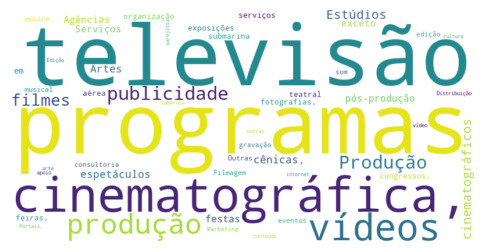

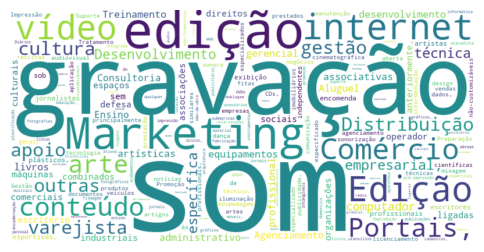

In [10]:
#Lista de palavras da tabela de produtoras independentes para excluir
palavras_excluir = ['de', 'e', 'não', 'anteriormente', 'Atividades', 'especificadas', 'para', 'atividades',\
                     'especificados', 'complementares', 'à', 'na', 'direto', 'outros', 'informação', 'provedores']
palavras_frequencia = [palavra for palavra in palavra if palavra not in palavras_excluir]
# palavras_frequencia = co(palavras_frequencia)
# Suponha que você tenha a lista de palavras filtradas armazenada em 'palavras_frequencia'
palavras_frequencia = [palavra for palavra in palavra if palavra not in palavras_excluir]

# Crie um objeto Counter com as palavras filtradas
contador_palavras = co(palavras_frequencia)

# Obtenha as 25 palavras mais comuns
maior_frequencia = contador_palavras.most_common(50)
menor_frequencia = contador_palavras.most_common()[-399:]

# Converta as palavras e suas frequências em um dicionário
dic_palavras_maior_frequencia = dict(maior_frequencia)
dic_palavras_menor_frequencia = dict(menor_frequencia)

# Crie uma nuvem de palavras para as 25 palavras mais comuns
nuvem_palavras_maior_frequencia = wc(width=800, height=400, background_color='white').generate_from_frequencies(dic_palavras_maior_frequencia)

# Plote a nuvem de palavras para as 25 palavras mais comuns
print('Nuvem de palavras com as 50 mais recorrentes entre as Atividades Econômicas')
plt.figure(figsize=(6, 4))
plt.imshow(nuvem_palavras_maior_frequencia, interpolation='bilinear')
plt.axis('off')
# plt.show()

# Crie uma nuvem de palavras para as 415 palavras menos comuns
nuvem_palavras_menor_frequencia = wc(width=800, height=400, background_color='white').generate_from_frequencies(dic_palavras_menor_frequencia)

# Plote a nuvem de palavras para as 415 palavras menos comuns
print('Nuvem de palavras com as 400 menos recorrentes entre as Atividades Econômicas')
plt.figure(figsize=(6, 4))
plt.imshow(nuvem_palavras_menor_frequencia, interpolation='bilinear')
plt.axis('off')
# plt.show()

A nuvem de palavras nos mostra a diversidade de atividades econômicas dentre os agentes com classificação de nível de produtora. Vamos analisar a distribuição geográfica desses agentes

---

**Qual a distribuição geográfica dos agentes econômicos no Brasil**

Observa-se uma concentração considerável de agentes econômicos nos estados de São Paulo (SP) e Rio de Janeiro (RJ) no setor audiovisual. Tal concentração é influenciada pela centralização das atividades de mercado e da disponibilidade de mão de obra qualificada nesses dois estados.

Além da concentração de agentes dos estados de SP e RJ, vemos também uma concentração evidente nas regiões Sul e Sudeste. Vejamos esse mapa de distribuição:

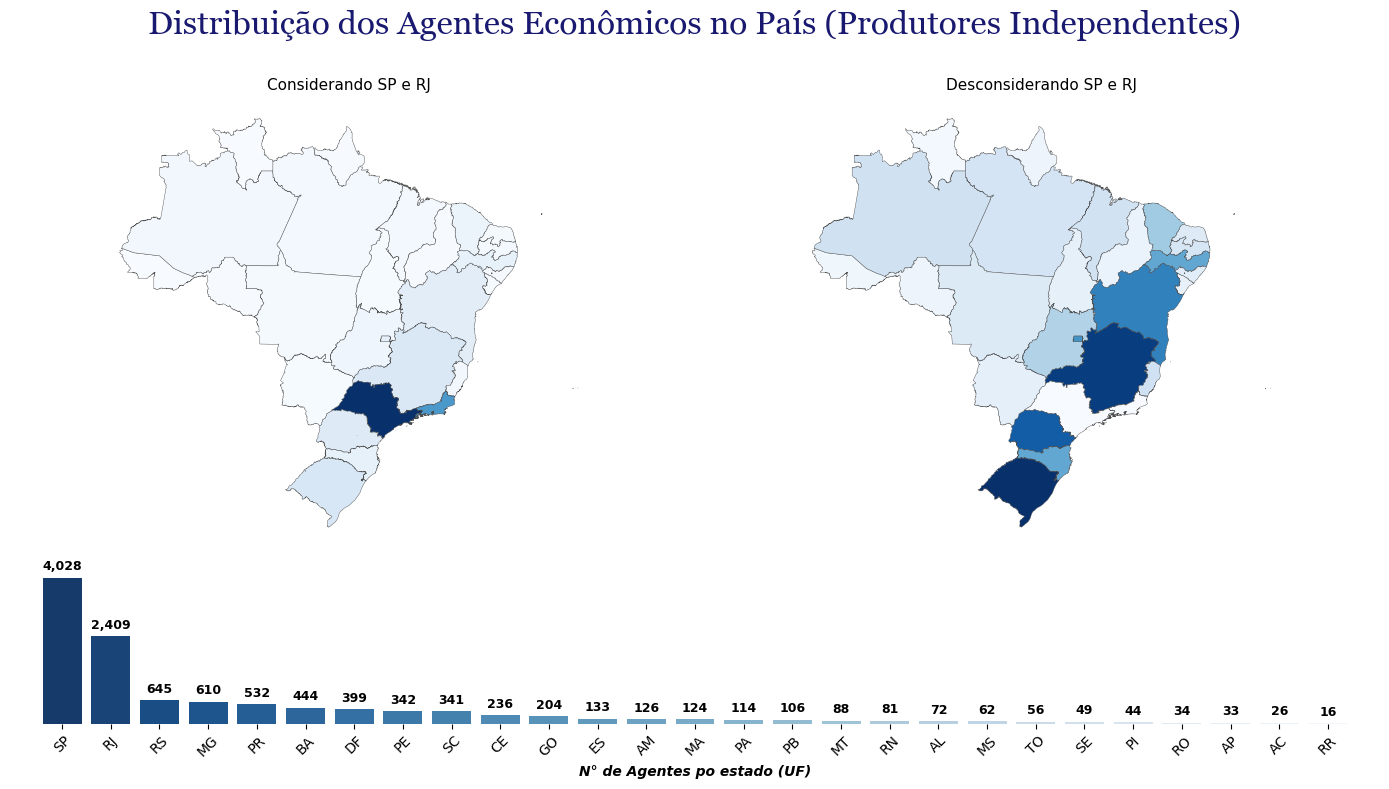

In [11]:
# Carregar mapa BR
brasil = gpd.read_file('C:\\Users\\syafo\\OneDrive\\Documentos\\GitHub\\AgenciaNacionalDoCinema_ANCINE\\geopandas\\BR_UF_2022.shp')

# Plot com todos os estados
totais_por_estado = agnts_tabela_unificada['UF'].value_counts().reset_index()
totais_por_estado.columns = ['UF', 'Total']

brasil = brasil.merge(totais_por_estado, left_on='SIGLA_UF', right_on='UF')

# Filtrar os dados excluindo SP e RJ
estados_sem_sp_rj = agnts_tabela_unificada[(agnts_tabela_unificada['UF'] != 'RJ') & (agnts_tabela_unificada['UF'] != 'SP')]
estados_count = estados_sem_sp_rj['UF'].value_counts().reset_index()
estados_count.columns = ['UF', 'Total']

# Adicionar linhas para SP e RJ com total zero
sp_row = pd.DataFrame({'UF': ['SP'], 'Total': [0]})
rj_row = pd.DataFrame({'UF': ['RJ'], 'Total': [0]})
estados_count = pd.concat([estados_count, sp_row, rj_row], ignore_index=True)

estados_count = estados_count.sort_values(by='UF')
estados_count = estados_count.rename(columns={'UF': 'UF_count', 'Total': 'Total_count'})
brasil_estados = brasil.merge(estados_count, left_on='SIGLA_UF', right_on='UF_count')

# Criar a figura
plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1], width_ratios=[2, 2])
# Plotar mapa dos estados sem SP e RJ
ax1 = plt.subplot(gs[0,0])
brasil_estados.plot(column='Total', cmap='Blues', linewidth=0.3, ax=ax1, edgecolor='0.3', legend=False)
ax1.set_title('Considerando SP e RJ', fontsize=11, fontweight='light')
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Plotar mapa dos estados com SP e RJ
ax2 = plt.subplot(gs[0,1])
brasil_estados.plot(column='Total_count', cmap='Blues', linewidth=0.3, ax=ax2, edgecolor='0.3', legend=False)
ax2.set_title('Desconsiderando SP e RJ', fontsize=11, fontweight='light')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Plotar gráfico de barras
ax3 = plt.subplot(gs[1, :])
sns.countplot(data=agnts_tabela_unificada, x='UF', order=agnts_tabela_unificada['UF'].value_counts().index, palette='Blues_r', ax=ax3)
for p in ax3.patches:
    ax3.annotate(format(p.get_height(), ',.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 8), 
                   textcoords='offset points',
                   fontsize=9, fontweight='bold')
# ax3.set_title('Quantidade de Agentes Econômicos por Estado', fontsize=13, fontweight='medium')
ax3.set_xlabel('N° de Agentes po estado (UF)', fontsize=10, fontweight='bold', fontstyle='oblique')
ax3.set_ylabel(None)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, fontsize=10, fontweight='normal') 
ax3.set_yticks([])
ax3.margins(0.025)
plt.tight_layout()
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}

plt.suptitle('Distribuição dos Agentes Econômicos no País (Produtores Independentes)', fontdict=fontprops, fontsize=24)
plt.subplots_adjust(top=0.87)
plt.show()


Para melhor compreender a distribuição dos agentes econômicos, é necessário considerar a exclusão de SP e RJ da análise. Ao realizar essa exclusão, evidenciam-se padrões diferentes de distribuição, refletindo uma dispersão mais equitativa da atividade econômica pelo território nacional. Essa alteração na distribuição reflete as dinâmicas regionais específicas do setor audiovisual fora dos polos tradicionais, revelando potenciais áreas de crescimento e desenvolvimento em outras regiões do país, como os estados da Bahia e Pernambuco, além do Distrito Federal.

Gráfico de comparação entre o número de produtoras na capital vs a somatória de produtoras fora da capital (Excluindo SP, RJ e o Distrito Federal)

Esse próximo painel constatamos 3 informações distintas e incomuns: Curiosamente, enquanto Santa Catarina é o único estado da federação onde o número de produtores em municípios não capitalinos supera o número na capital Florianópolis, Espírito Santo é o estado com a divisão mais equalizada: 49.6% em Vitória e 50.4% fora da capital. Além disso, no estado de Roraima 100% dos produtores estão na capital Boa Vista.

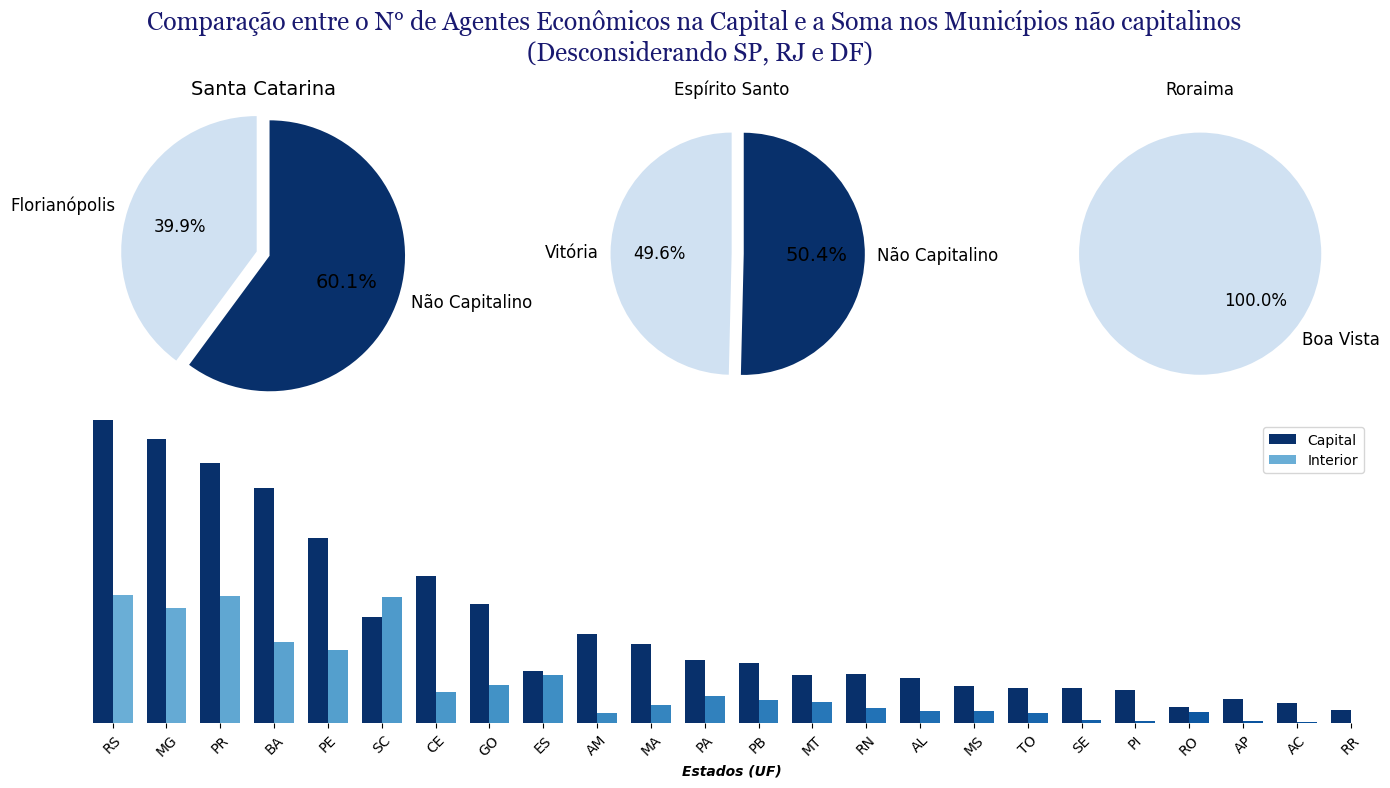

In [12]:
#Gráficos de Pizza
santa_catarina = agnts_tabela_unificada.query("UF == 'SC'")['MUNICIPIO'].value_counts()
roraima = agnts_tabela_unificada.query("UF == 'RR'")['MUNICIPIO'].value_counts()
espirito_santo = agnts_tabela_unificada.query("UF == 'ES'")['MUNICIPIO'].value_counts()

santa_catarina_interior = santa_catarina.sum() - santa_catarina.iloc[0]
roraima_interior = roraima.sum() - roraima.iloc[0]
espirito_santo_interior = espirito_santo.sum() - espirito_santo.iloc[0]

santa_catarina_pie = {'Florianópolis': 136,
                        'Não Capitalino' : 205}

roraima_pie = {'Boa Vista': 16}

espirito_santo_pie = {'Vitória' : 66,
                      'Não Capitalino' : 67}

cores_sc = plt.cm.Blues(np.linspace(0.2, 1, len(santa_catarina_pie)))
cores_es = plt.cm.Blues(np.linspace(0.2, 1, len(roraima_pie)))
cores_rr = plt.cm.Blues(np.linspace(0.2, 1, len(espirito_santo_pie)))

####

#Gráfico de Barras
#Função para comparar o número de Agentes Econômicos nas capitais e no interior dos UFs
def capital_vs_interior(uf, produtora_classificacao):
    separar_uf = produtora_classificacao[produtora_classificacao['UF'] == uf]
    capital = separar_uf['MUNICIPIO'].value_counts().head(1)
    interior = separar_uf['MUNICIPIO'].value_counts().head(15).sum() - capital 
    nome_capital = capital.index[0]
    capital.rename(index={nome_capital : 'Capital'}, inplace=True)
    interior.rename(index={nome_capital : 'Interior'}, inplace=True)
    return capital, interior

estados = [ 'RS', 'MG', 'PR', 'BA', 'PE', 'SC', 
           'CE', 'GO', 'ES', 'AM', 'MA', 'PA', 'PB', 'MT', 
           'RN', 'AL', 'MS', 'TO', 'SE', 'PI', 'RO', 'AP', 'AC', 'RR'] #Lista de UFs

capitais = []
interiores = [] #lista para armazenar os valores

for uf in estados: #Loop for sobre cada estado
    capital, interior = capital_vs_interior(uf, agnts_tabela_unificada)
    capitais.append(capital)
    interiores.append(interior)


#####
plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 3, height_ratios=[3, 3], width_ratios=[3, 3, 3])


##########################################

# Pie - Santa Catarina
ax1 = plt.subplot(gs[0, 0])
wedges, texts, autotexts = ax1.pie(santa_catarina_pie.values(), labels=santa_catarina_pie.keys(), 
                                   colors=cores_sc, autopct='%1.1f%%', startangle=90, 
                                   explode=(0, 0.1), textprops={'fontsize': 12, 'fontweight': 'medium'})


autotexts[1].set_fontsize(14)
autotexts[1].set_fontweight('medium')
ax1.axis('equal')
ax1.grid(False)
ax1.set_title('Santa Catarina', fontsize=14, fontweight='medium')
ax1.set_xlabel(None)
ax1.set_ylabel(None)
ax1.set_yticks([])
ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

#Pie - Espírito Santo
ax2 = plt.subplot(gs[0, 1])
wedges, texts, autotexts = ax2.pie(espirito_santo_pie.values(), labels=espirito_santo_pie.keys(), 
                                   colors=cores_sc, autopct='%1.1f%%', startangle=90, 
                                   explode=(0, 0.1), textprops={'fontsize': 12, 'fontweight': 'medium'})


autotexts[1].set_fontsize(14)
autotexts[1].set_fontweight('medium')
ax1.axis('equal')
ax1.grid(False)
ax2.set_title('Espírito Santo', fontsize=12, fontweight='medium')
ax2.set_xlabel(None)
ax2.set_ylabel(None)
ax2.set_yticks([])
ax2.set_xticks([])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

#Pie - Roraima
ax3 = plt.subplot(gs[0,2])
ax3.pie(roraima_pie.values(), labels=roraima_pie.keys(),colors=cores_rr,  
           autopct='%1.1f%%', startangle=140, shadow=False, textprops={'fontsize': 12, 'fontweight': 'medium'})
ax3.set_title('Roraima', fontsize=12, fontweight='medium')
ax3.set_xlabel(None)
ax3.set_ylabel(None)
ax3.set_yticks([])
ax3.set_xticks([])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['bottom'].set_visible(False)


#############
#Criação do Plot com 3 gráficos 
#Gráfico de barras       
bar_width = 0.37 #largura das barras
r1 = np.arange(len(estados)) #posição das barras
r2 = [x + bar_width for x in r1] #posição das barras
cores_int = plt.cm.Blues(np.linspace(0.5, 0.9, len(estados))) #definindo cores
cores_cap = plt.cm.Blues(np.linspace(1, 2, len(estados))) #definindo cores

ax4 = plt.subplot(gs[1, :])
# Plot das capitais
ax4 = plt.bar(r1, [c.values[0] for c in capitais], color=cores_cap, width=bar_width, label='Capital')

# Plot dos interiores
ax4 = plt.bar(r2, [i.values[0] for i in interiores], color=cores_int, width=bar_width, label='Interior')

ax4 = plt.xlabel('Estados (UF)', fontsize=10, fontweight='bold', fontstyle='oblique')
ax4 = plt.ylabel(None)
ax4 = plt.xticks([r + bar_width/2 for r in range(len(estados))], estados)  # Definindo os rótulos do eixo x como os estados
ax4 = plt.legend()
ax4 = plt.xticks(rotation=45, fontweight='medium')
ax4 = plt.yticks([])
ax4 = plt.margins(False)
ax4 = plt.box([])


fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
plt.suptitle('Comparação entre o N° de Agentes Econômicos na Capital e a Soma nos Municípios não capitalinos \n (Desconsiderando SP, RJ e DF)', fontdict=fontprops, fontsize=18)
plt.subplots_adjust(top=0.87)
plt.tight_layout()
plt.show()


Estudando mais o tema, vamos analisar o ranking de natureza juridica dos agentes econômicos

In [13]:
#Naturezas Jurídicas
consultas = {
    'ltda': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Empresária Limitada'"),
    'mei': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresário (Individual)'"),
    'eireli_empresaria': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresa Individual de Responsabilidade Limitada (de Natureza Empresária)'"),
    'ss_limitada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Simples Limitada'"),
    'associacao_privada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Associação Privada'"),
    'eireli_simples': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Empresa Individual de Responsabilidade Limitada (de Natureza Simples)'"),
    'sa_fechada': agnts_tabela_unificada.query("NATUREZA_JURIDICA == 'Sociedade Anônima Fechada'")
}

globals().update(consultas)

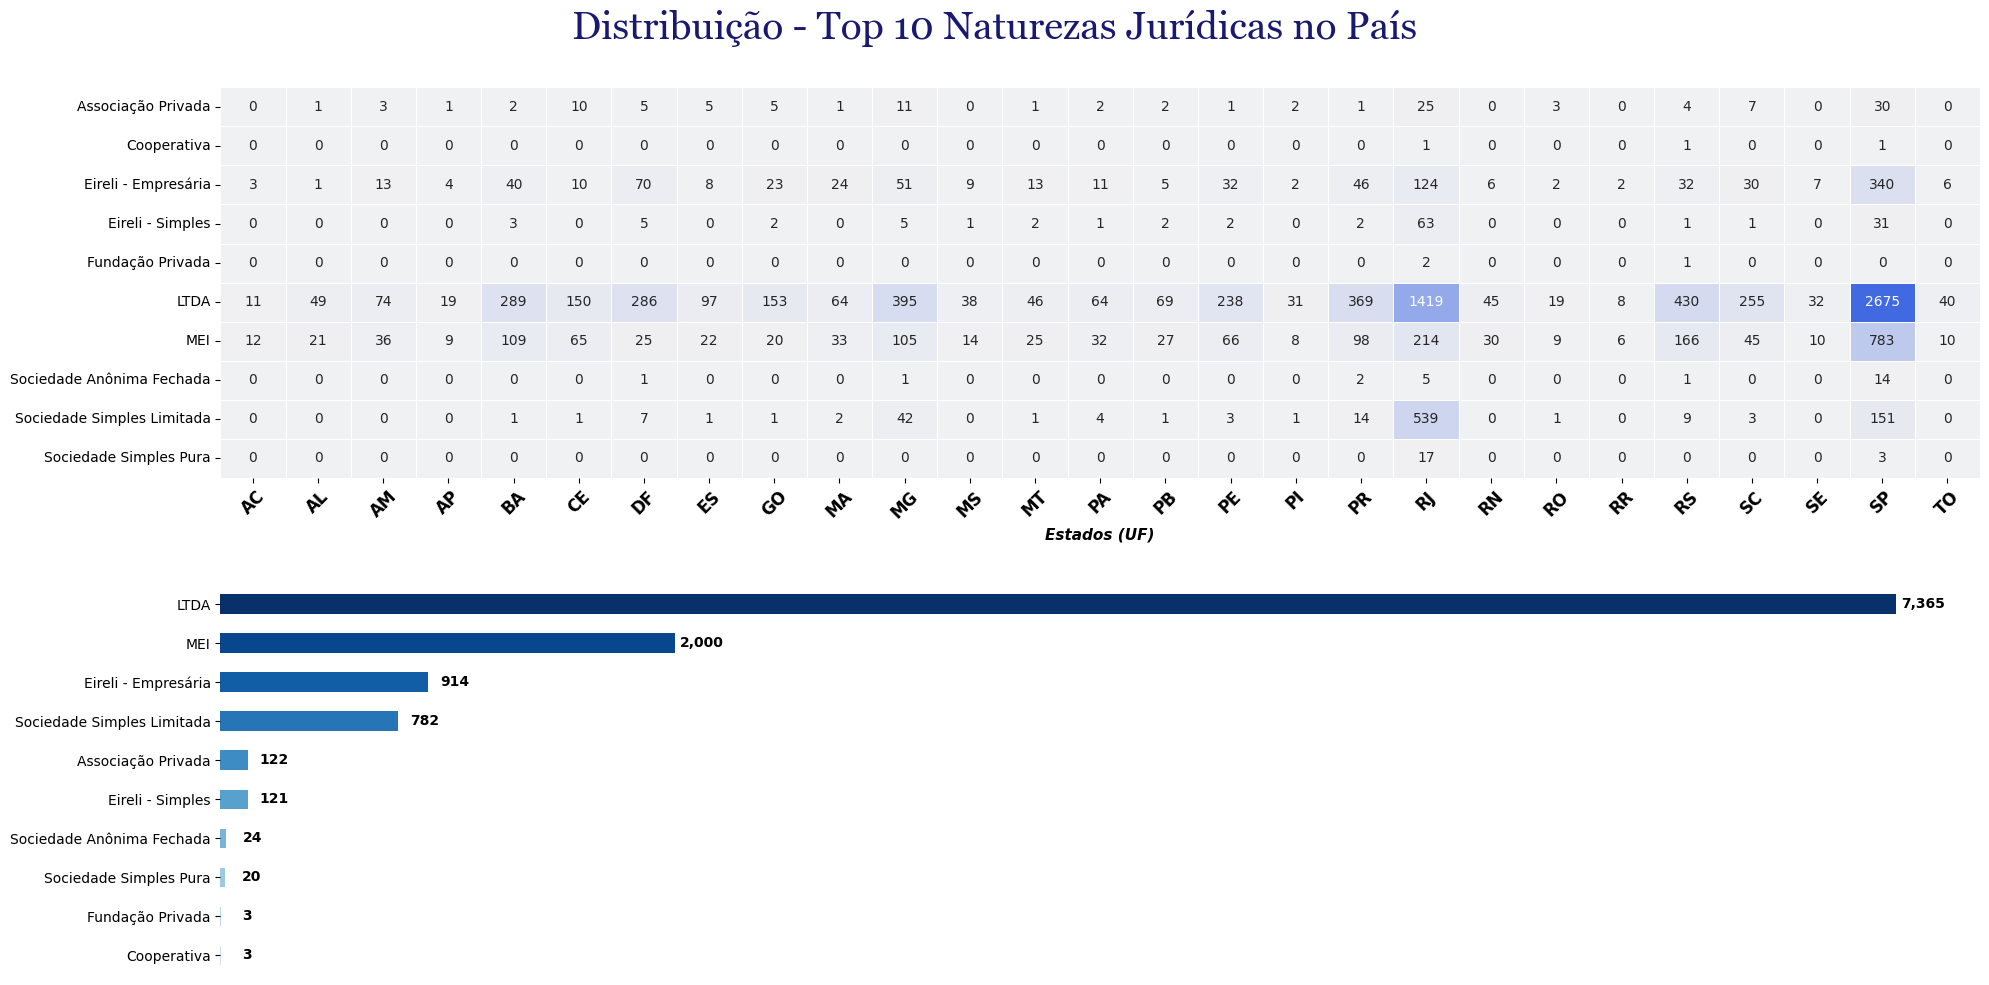

In [14]:
plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 1)
axs = [plt.subplot(gs[i]) for i in range(2)]


natureza_juridica = pd.DataFrame(agnts_tabela_unificada)
natureza_juridica['NATUREZA_JURIDICA'] = natureza_juridica['NATUREZA_JURIDICA'].replace({
    'Sociedade Empresária Limitada': 'LTDA',
    'Empresário (Individual)': 'MEI',
    'Empresa Individual de Responsabilidade Limitada (de Natureza Empresária)': 'Eireli - Empresária',
    'Empresa Individual de Responsabilidade Limitada (de Natureza Simples)': 'Eireli - Simples'
})
ranking_natureza_juridica_top_10 = natureza_juridica['NATUREZA_JURIDICA'].value_counts().head(10)

cores = plt.cm.Blues(np.linspace(0.2, 1, len(ranking_natureza_juridica_top_10)))
ranking_natureza_juridica_top_10.sort_values(ascending=True).plot(kind='barh', color=cores, ax=axs[1])

for n in axs[1].patches:
    axs[1].annotate(format(n.get_width(), ',.0f'),
                    (n.get_width(), n.get_y() + n.get_height() / 2.),
                    ha='center', va='center',
                    xytext=(19, 0),
                    textcoords='offset points',
                    fontsize=10, fontweight='bold')

axs[1].set_title('   ', fontsize=17, fontweight='medium')
axs[1].set_ylabel(None)
axs[1].set_xlabel(None)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontweight='medium')
axs[1].set_xticks([])
# axs[0].box(False)
# axs[0].set_yticks(fontweight='bold')
# axs[0].tight_layout()


pivot_table = pd.crosstab(natureza_juridica['NATUREZA_JURIDICA'], natureza_juridica['UF'])
cor = sns.color_palette("light:royalblue", as_cmap=True)
axs[0] = sns.heatmap(pivot_table, annot=True, fmt='d', linewidths=0.5, cmap=cor, ax=axs[0], cbar=False)
axs[0].set_xlabel('Estados (UF)', fontweight='bold', fontsize=11, fontstyle='oblique')
axs[0].set_ylabel(None)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontweight='medium', rotation=0)
axs[0].set_xticklabels(axs[0].get_xticklabels(), fontweight='bold', fontsize=12, rotation=45)
axs[0].set_title("   ", fontsize=20)

fontprops = {'color': 'midnightblue', 'weight': 'bold', 'style': 'normal', 'family' : 'Georgia'}
plt.suptitle('Distribuição - Top 10 Naturezas Jurídicas no País', fontdict=fontprops, fontsize=28)
plt.subplots_adjust(top=1.87)
plt.subplots_adjust(hspace=1.5)
# plt.suptitle('Quantidade de Agentes por natureza jurídica', fontsize=14)
plt.box([])
plt.tight_layout()
plt.show()


Apesar da natureza jurídica LTDA (Sociedade Empresária Limitada) controlar majoritariamente a arrecadação no mercado, o MEI (Micro Empreendedor Individual) desempenha um papel significativo na indústria audiovisual brasileira, principalmente em um contexto de transformação digital e na democratização da produção de conteúdo. Através do MEI produtores independentes tem acesso a uma estrutura jurídica simplificada e custos operacionais mais baixos em relação à outras naturezas jurídicas, possibilitando que futuros profissionais da inústria começem seus próprios negócios com mais facilidade. 

Vejamos as classificações de nível de produtora:

In [15]:
nivel_produtora_5 = agnts_tabela_unificada[(agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 5.0)].count()
nivel_produtora_5_sp = nivel_produtora_5[nivel_produtora_5['UF'] == 'SP'].count()
nivel_produtora_5_br = nivel_produtora_5['UF']value

nivel_produtora = agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'].value_counts()
plt.figure(figsize=(13,4))
cores = plt.cm.Blues(np.linspace(0.1, 1, len(nivel_produtora)))
ax = nivel_produtora.sort_values(ascending=True).plot(kind='barh', color=cores)

for n in ax.patches:
        ax.annotate(format(n.get_width(), ',.0f'),
                (n.get_width(), n.get_y() + n.get_height() / 2.),
                ha='center', va='center',
                xytext=(19, 0),
                textcoords='offset points',
                fontsize=9, fontweight='bold')
        
plt.ylabel(None)
plt.title('Quantidade de produtores por Nível (ANCINE)')
plt.yticks(fontsize=8)
plt.box(False)
plt.tight_layout()
plt.show()

KeyError: False

In [ ]:
nivel_produtora_5

REGISTRO_ANCINE                  61
DATA_REGISTRO                    61
RAZAO_SOCIAL                     61
CNPJ                             61
DATA_CONSTITUICAO                61
UF                               61
MUNICIPIO                        61
NATUREZA_JURIDICA                61
ATIVIDADE_ECONOMICA              61
CLASSIFICACAO_ATIVIDADE          61
BRASILEIRO_INDEPENDENTE          61
CLASSIFICACAO_NIVEL_PRODUTORA    61
PRODUTORA_INDEPENDENTE           61
dtype: int64

In [ ]:
classificacao_1 = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 1.0]
classificacao_2 = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 2.0]
classificacao_3 = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 3.0]
classificacao_4 = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 4.0]
classificacao_5 = agnts_tabela_unificada[agnts_tabela_unificada['CLASSIFICACAO_NIVEL_PRODUTORA'] == 5.0]

---

In [ ]:

renun_fiscal_captados = proj_renuncia_fiscal.copy()
renun_fiscal_captados['TOTAL_CAPTADO'] = renun_fiscal_captados['TOTAL_CAPTADO'].str.split(',').apply(lambda x: [float(i) for i in x]).apply(sum)
valor_captado_produtoras = renun_fiscal_captados.groupby(['RAZAO_SOCIAL_PROPONENTE', 'CNPJ_PROPONENTE'])['TOTAL_CAPTADO'].sum().reset_index()
produtoras_proj_renun_fiscal = valor_captado_produtoras.sort_values(by='TOTAL_CAPTADO', ascending=False)

produtoras_proj_renun_fiscal = agnts_tabela_unificada.merge(produtoras_proj_renun_fiscal, left_on='CNPJ', right_on='CNPJ_PROPONENTE')
produtoras_proj_renun_fiscal

,REGISTRO_ANCINE,DATA_REGISTRO,RAZAO_SOCIAL,CNPJ,DATA_CONSTITUICAO,UF,MUNICIPIO,NATUREZA_JURIDICA,ATIVIDADE_ECONOMICA,CLASSIFICACAO_ATIVIDADE,BRASILEIRO_INDEPENDENTE,CLASSIFICACAO_NIVEL_PRODUTORA,PRODUTORA_INDEPENDENTE,RAZAO_SOCIAL_PROPONENTE,CNPJ_PROPONENTE,TOTAL_CAPTADO
0,1,2002-12-18,M. ALTBERG CINEMA E VÍDEO LTDA,39.939.269/0001-73,1993-01-05,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0,True,M. ALTBERG CINEMA E VÍDEO LTDA,39.939.269/0001-73,1198462.0
1,3,2002-05-28,RIO DE CINEMA PRODUÇÕES CULTURAIS,03.984.281/0001-52,2000-08-09,RJ,RIO DE JANEIRO,Sociedade Simples Limitada,"Atividades de produção cinematográfica, de víd...",1,True,2.0,True,RIO DE CINEMA PRODUÇÕES CULTURAIS,03.984.281/0001-52,1641178.0
2,4,2002-05-28,SM PRODUÇÕES LTDA,27.815.174/0001-69,1982-08-17,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0,True,SM PRODUÇÕES LTDA,27.815.174/0001-69,230000.0
3,6,2003-08-26,TELENEWS SERVICE LTDA,31.553.936/0001-73,1987-08-14,RJ,RIO DE JANEIRO,Sociedade Simples Limitada,"Atividades de produção cinematográfica, de víd...",1,True,2.0,True,TELENEWS SERVICE LTDA,31.553.936/0001-73,940000.0
4,10,2002-06-28,CONSPIRAÇÃO FILMES S/A,02.020.661/0001-04,1997-06-27,RJ,RIO DE JANEIRO,Sociedade Anônima Fechada,"Atividades de produção cinematográfica, de víd...",1,True,5.0,True,CONSPIRAÇÃO FILMES S/A,02.020.661/0001-04,116859763.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,44985,2020-01-27,BICICLETA BRANCA CRIAÇÕES E PRODUÇÕES LTDA,32.216.407/0001-47,2018-12-10,SP,SÃO PAULO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0,True,BICICLETA BRANCA CRIAÇÕES E PRODUÇÕES LTDA,32.216.407/0001-47,150000.0
751,45227,2020-03-02,KILOMBA PRODUCOES LTDA,33.163.124/0001-47,2019-03-27,RJ,RIO DE JANEIRO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0,True,KILOMBA PRODUCOES LTDA,33.163.124/0001-47,675000.0
752,46150,2020-07-21,FLUXA FILMES LTDA,34.878.582/0001-25,2019-09-16,SP,SÃO PAULO,Sociedade Empresária Limitada,"Atividades de produção cinematográfica, de víd...",1,True,1.0,True,FLUXA FILMES LTDA,34.878.582/0001-25,1550000.0
753,48102,2021-04-06,VAMO QUE VAMO FILMES - EIRELI,32.785.981/0001-16,2019-02-15,RJ,RIO DE JANEIRO,Empresa Individual de Responsabilidade Limitad...,"Atividades de produção cinematográfica, de víd...",1,True,1.0,True,VAMO QUE VAMO FILMES - EIRELI,32.785.981/0001-16,1626000.0


---

## Séries Temporais

### Projetos de Renúncia Fiscal

Os dados dos projetos de renúncia fiscal apresenta uma série temporal irregular, as colunas de datas de aprovação e liberação não apresentam intervalos regulares.

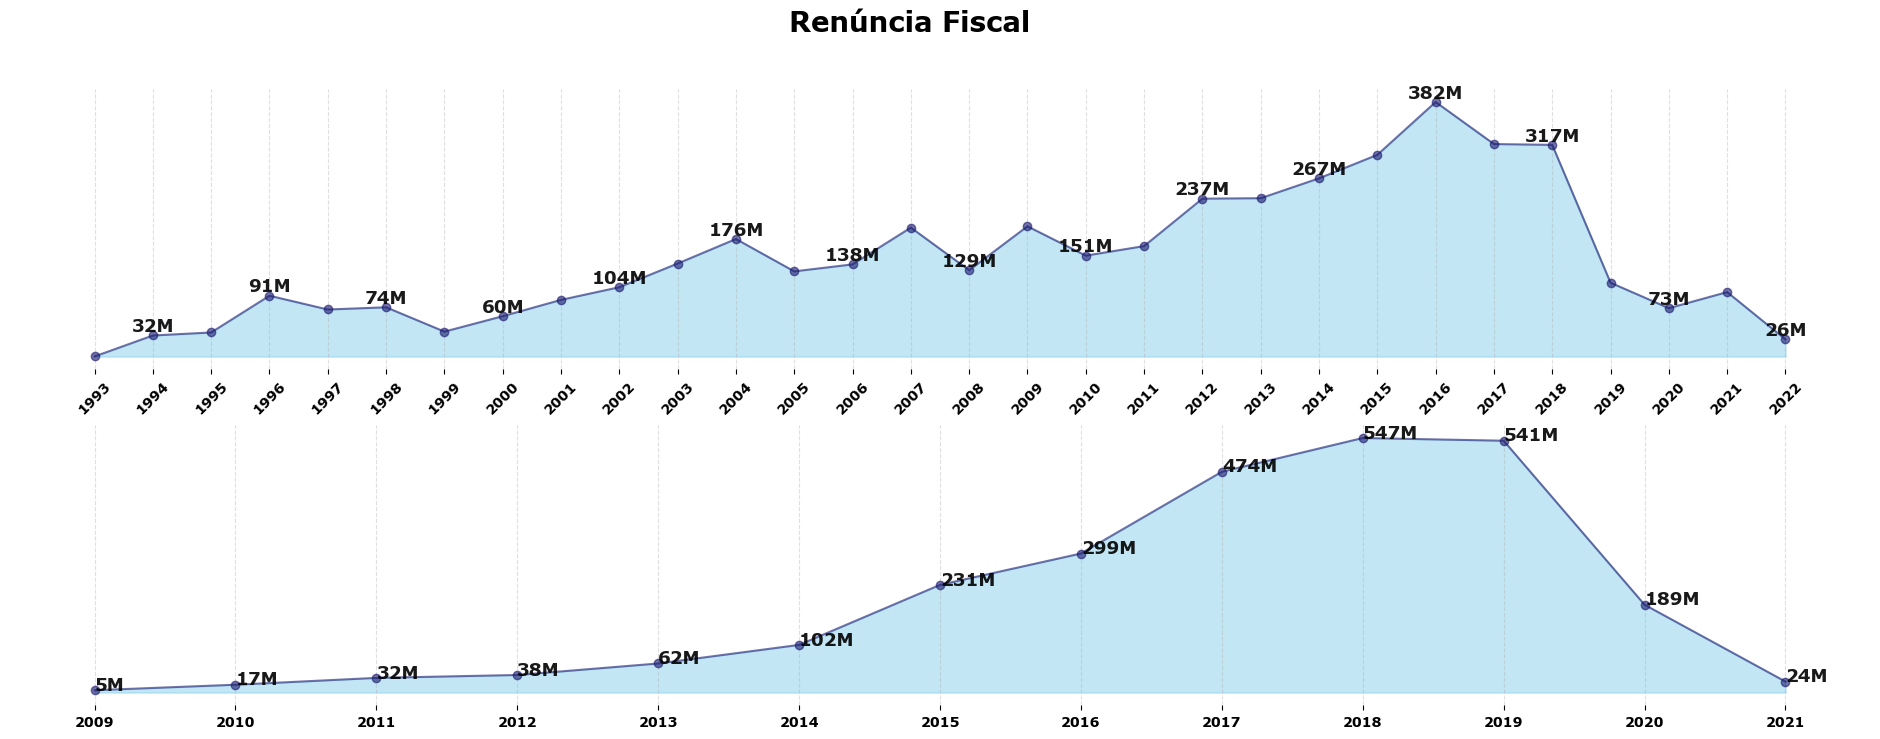

In [ ]:

df_serie_temp_renun_fiscal = proj_renuncia_fiscal[['DT_APROVACAO_CAPTACAO', 'TOTAL_CAPTADO']]
df_serie_temp_renun_fiscal['TOTAL_CAPTADO'] = df_serie_temp_renun_fiscal['TOTAL_CAPTADO'].str.replace(',', '.').astype(float)
df_serie_temp_renun_fiscal['DT_APROVACAO_CAPTACAO'] = df_serie_temp_renun_fiscal['DT_APROVACAO_CAPTACAO'].dt.year
df_serie_temp_renun_fiscal = df_serie_temp_renun_fiscal.set_index('DT_APROVACAO_CAPTACAO')['TOTAL_CAPTADO']
df_serie_temp_renun_fiscal = df_serie_temp_renun_fiscal.groupby(df_serie_temp_renun_fiscal.index).sum().reset_index()
df_serie_temp_renun_fiscal_ano = df_serie_temp_renun_fiscal.set_index('DT_APROVACAO_CAPTACAO')['TOTAL_CAPTADO']

df_serie_temp_fsa_desembolso = proj_fsa_desembolso[['DT_PRIMEIRO_DESEMBOLSO', 'VL_TOTAL_LIBERADO']]
df_serie_temp_fsa_desembolso['VL_TOTAL_LIBERADO'] = df_serie_temp_fsa_desembolso['VL_TOTAL_LIBERADO'].str.replace(',', '.').astype(float)
df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'] = df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'].dt.year
df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.dropna(subset=['DT_PRIMEIRO_DESEMBOLSO'])
df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'] = df_serie_temp_fsa_desembolso['DT_PRIMEIRO_DESEMBOLSO'].astype(int)
df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.set_index('DT_PRIMEIRO_DESEMBOLSO')['VL_TOTAL_LIBERADO']
df_serie_temp_fsa_desembolso = df_serie_temp_fsa_desembolso.groupby(df_serie_temp_fsa_desembolso.index).sum().reset_index()
df_serie_temp_fsa_desembolso_ano = df_serie_temp_fsa_desembolso.set_index('DT_PRIMEIRO_DESEMBOLSO')['VL_TOTAL_LIBERADO']



#
plt.figure(figsize=(24, 8))
gs = gridspec.GridSpec(2, 1)
axs = [plt.subplot(gs[i]) for i in range(2)]



def valor_index(df, numero):
    count = 0
    for index, valor in df.items():
        milhoes = valor / 1e6
        
        if numero == 0:
            count += 1 
            if count % 2 == 0:
                axs[0].text(index, valor, f"{milhoes:.0f}M", ha='center', va='bottom', fontweight='bold', fontsize=13, color='k', alpha=0.9)
            else:
                pass
        else:
            axs[1].text(index, valor, f"{milhoes:.0f}M", fontweight='bold', fontsize=13, color='k', alpha=0.9)

valor_index(df_serie_temp_fsa_desembolso_ano, 1)
valor_index(df_serie_temp_renun_fiscal_ano, 0)

axs[0].set_xticks(df_serie_temp_renun_fiscal_ano.index)
axs[0].set_xticklabels(df_serie_temp_renun_fiscal_ano.index, rotation=45, fontweight='bold', alpha=1)
axs[0].fill_between(df_serie_temp_renun_fiscal_ano.index, df_serie_temp_renun_fiscal_ano.values, color="skyblue", alpha=0.5)
axs[0].tick_params(axis='x', which='minor', width=5)
axs[0].set_yticks([])
axs[0].grid(linestyle='dashed', alpha=0.4)
axs[0].plot(df_serie_temp_renun_fiscal_ano.index, df_serie_temp_renun_fiscal_ano.values, color='midnightblue', marker='o', alpha=0.6, label='Serie Temp Renun Fiscal Ano')
            
axs[1].set_xticks(df_serie_temp_fsa_desembolso_ano.index)
axs[1].set_xticklabels(df_serie_temp_fsa_desembolso_ano.index, rotation=0, fontweight='bold', alpha=1)
axs[1].fill_between(df_serie_temp_fsa_desembolso_ano.index, df_serie_temp_fsa_desembolso_ano.values, color="skyblue", alpha=0.5)
axs[1].tick_params(axis='x', which='minor', width=5)
axs[1].set_yticks([])
axs[1].grid(linestyle='dashed', alpha=0.4)
axs[1].plot(df_serie_temp_fsa_desembolso_ano.index, df_serie_temp_fsa_desembolso_ano.values, color='midnightblue', marker='o', alpha=0.6, label='Serie Temp Fsa Desembolso Ano')


for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.suptitle('Renúncia Fiscal', fontsize=20, fontweight='bold')
plt.show()



---


**Qual é a distribuição geográfica das produções cinematográficas no Brasil? Há concentração em determinadas regiões?**  

**Qual é o perfil dos investidores na indústria cinematográfica brasileira? Há diferenças significativas entre investidores de produções de grande escala e produções independentes?**  

In [ ]:
# #Projetos realizados através de Renúncia Fiscal
# num_proj_renun_fiscal_natureza_economica = proj_renuncia_fiscal.copy()
# num_proj_renun_fiscal_natureza_economica['TOTAL_CAPTADO'] = num_proj_renun_fiscal_natureza_economica['TOTAL_CAPTADO'].str.split(',').apply(lambda x: [float(i) for i in x]).apply(sum)
# num_proj_renun_fiscal_natureza_economica = agnts_tabela_unificada.merge(num_proj_renun_fiscal_natureza_economica, left_on='CNPJ', right_on='CNPJ_PROPONENTE')
# num_proj_renun_fiscal_natureza_economica = num_proj_renun_fiscal_natureza_economica[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL', 'CNPJ',
#        'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA',
#        'ATIVIDADE_ECONOMICA', 'CLASSIFICACAO_ATIVIDADE',
#        'BRASILEIRO_INDEPENDENTE', 'CLASSIFICACAO_NIVEL_PRODUTORA',
#        'PRODUTORA_INDEPENDENTE', 'TITULO_PROJETO',
#        'MUNICIPIO_PROPONENTE', 'UF_PROPONENTE', 'SITUACAO_REGISTRO',
#        'CNPJ_PROPONENTE', 'RAZAO_SOCIAL_PROPONENTE', 'TOTAL_CAPTADO',
#        'DT_APROVACAO_CAPTACAO', 'DT_1_LIBERACAO']]

# num_proj_renun_fiscal_natureza_economica_ltda = num_proj_renun_fiscal_natureza_economica[num_proj_renun_fiscal_natureza_economica['NATUREZA_JURIDICA'] == 'Sociedade Empresária Limitada']
# num_proj_renun_fiscal_natureza_economica_mei = num_proj_renun_fiscal_natureza_economica[num_proj_renun_fiscal_natureza_economica['NATUREZA_JURIDICA'] == 'Empresário (Individual)']
# num_proj_renun_fiscal_natureza_economica_eireli_empresarial = num_proj_renun_fiscal_natureza_economica[num_proj_renun_fiscal_natureza_economica['NATUREZA_JURIDICA'] == 'Empresa Individual de Responsabilidade Limitada (de Natureza Empresária)']
# num_proj_renun_fiscal_natureza_economica_ss_limitada = num_proj_renun_fiscal_natureza_economica[num_proj_renun_fiscal_natureza_economica['NATUREZA_JURIDICA'] == 'Sociedade Simples Limitada']
# num_proj_renun_fiscal_natureza_economica_associacao_privada = num_proj_renun_fiscal_natureza_economica[num_proj_renun_fiscal_natureza_economica['NATUREZA_JURIDICA'] == 'Associação Privada']
# num_proj_renun_fiscal_natureza_economica_eireli_simples = num_proj_renun_fiscal_natureza_economica[num_proj_renun_fiscal_natureza_economica['NATUREZA_JURIDICA'] == 'Empresa Individual de Responsabilidade Limitada (de Natureza Simples)']
# num_proj_renun_fiscal_natureza_economica_sa_fechada = num_proj_renun_fiscal_natureza_economica[num_proj_renun_fiscal_natureza_economica['NATUREZA_JURIDICA'] == 'Sociedade Anônima Fechada']

# ################
# #Projetos realizados através do Fundo Setorial Audiovisual (FSA) e Desembolso
# num_proj_fsa_desembolso_natureza_economica = proj_fsa_desembolso.copy()
# # num_proj_fsa_desembolso_natureza_economica['VL_TOTAL_LIBERADO'] = num_proj_fsa_desembolso_natureza_economica['VL_TOTAL_LIBERADO'].str.split(',').apply(lambda x: [float(i) for i in x]).apply(sum)
# num_proj_fsa_desembolso_natureza_economica = agnts_tabela_unificada.merge(num_proj_fsa_desembolso_natureza_economica, left_on='CNPJ', right_on='CNPJ_PROPONENTE')
# num_proj_fsa_desembolso_natureza_economica = num_proj_fsa_desembolso_natureza_economica[['REGISTRO_ANCINE', 'DATA_REGISTRO', 'RAZAO_SOCIAL', 'CNPJ',
#        'DATA_CONSTITUICAO', 'UF', 'MUNICIPIO', 'NATUREZA_JURIDICA',
#        'ATIVIDADE_ECONOMICA', 'CLASSIFICACAO_ATIVIDADE',
#        'BRASILEIRO_INDEPENDENTE', 'CLASSIFICACAO_NIVEL_PRODUTORA',
#        'PRODUTORA_INDEPENDENTE', 'TITULO_PROJETO',
#        'CHAMADA_PUBLICA', 'ANO_CHAMADA_PUBLICA', 'CNPJ_PROPONENTE',
#        'RAZAO_SOCIAL_PROPONENTE', 'VL_TOTAL_LIBERADO']]

# num_proj_fsa_desembolso_natureza_economica.sample(5)

# num_proj_fsa_desembolso_natureza_economica_ltda = num_proj_fsa_desembolso_natureza_economica[num_proj_fsa_desembolso_natureza_economica['NATUREZA_JURIDICA'] == 'Sociedade Empresária Limitada']
# num_proj_fsa_desembolso_natureza_economica_mei = num_proj_fsa_desembolso_natureza_economica[num_proj_fsa_desembolso_natureza_economica['NATUREZA_JURIDICA'] == 'Empresário (Individual)']
# num_proj_fsa_desembolso_natureza_economica_eireli_empresarial = num_proj_fsa_desembolso_natureza_economica[num_proj_fsa_desembolso_natureza_economica['NATUREZA_JURIDICA'] == 'Empresa Individual de Responsabilidade Limitada (de Natureza Empresária)']
# num_proj_fsa_desembolso_natureza_economica_ss_limitada = num_proj_fsa_desembolso_natureza_economica[num_proj_fsa_desembolso_natureza_economica['NATUREZA_JURIDICA'] == 'Sociedade Simples Limitada']
# num_proj_fsa_desembolso_natureza_economica_associacao_privada = num_proj_fsa_desembolso_natureza_economica[num_proj_fsa_desembolso_natureza_economica['NATUREZA_JURIDICA'] == 'Associação Privada']
# num_proj_fsa_desembolso_natureza_economica_eireli_simples = num_proj_fsa_desembolso_natureza_economica[num_proj_fsa_desembolso_natureza_economica['NATUREZA_JURIDICA'] == 'Empresa Individual de Responsabilidade Limitada (de Natureza Simples)']
# num_proj_fsa_desembolso_natureza_economica_sa_fechada = num_proj_fsa_desembolso_natureza_economica[num_proj_fsa_desembolso_natureza_economica['NATUREZA_JURIDICA'] == 'Sociedade Anônima Fechada']
